In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import sys

from shptools_BOULDERING import shp, geometry as shp_geom, geomorph as shp_geomorph, annotations as shp_anno, metrics as shp_metrics
from rastertools_BOULDERING import raster, metadata as raster_metadata, crs as raster_crs
from pathlib import Path
from tqdm import tqdm

## Download of data
In order to have the data required to go through this jupyter notebook, please follow the instructions at: [DOWNLOAD_DATA_BOULDERING.ipynb](./DOWNLOAD_DATA_BOULDERING.ipynb)

## Pre-processing of shapefiles and images into Detectron2 input format
See https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html for custom datasets.

This routine includes:
1. Select all of the boulder_mapping files and all of the region of mapping (ROM), and clip boulders to it (clip to patches).
2. Select already generated pickle files (contain information to tile rasters).
3. Read all boulder shapefiles and pickle files and concatenate them in one GeoDataframe/Dataframe (for each of them)
4. Specify main path to rasters.
5. Split in train-validation-test split based on selected percentages.
6. Tile rasters based on mapped patches.
7. Update absolute path to boulder mapping
8. Tile shapefiles from dataframe
9. Generate semantic segmentation mask (optional)
10. Save pickle (in case you want to re-run it)
11. Generate json for import in Detectron2 


### Inputs/Outputs

In [3]:
boulder_mapping_folder = Path("/home/nilscp/tmp/BOULDERING/raw_data/") # need to make it dependent on home folder
boulder_mapping_files = list(boulder_mapping_folder.rglob("*-boulder-mapping.shp")) # recursive search of all boulder mapping shapefiles
ROM_files = [Path(i.as_posix().replace("boulder-mapping", "ROM")) for i in boulder_mapping_files]
in_raster = [list((i.parent.parent / "raster").glob("*.tif"))[0] for i in boulder_mapping_files]
in_raster_res = [raster_metadata.get_resolution(i)[0] for i in in_raster]
areal_thresholds = [(i * i) * (4.74 * 4.74) for i in in_raster_res]
out_shps_clipped = [i.with_name(i.stem + "-clipped-to-ROM.shp") for i in boulder_mapping_files]

#### 1. Select all of the boulder_mapping files and all of the region of mapping (ROM), and clip boulders to it (clip to patches).

In [60]:
for i in range(len(boulder_mapping_files)):
    shp.clip(in_shp=boulder_mapping_files[i], mask_shp=ROM_files[i], min_area_threshold=areal_thresholds[i], out_shp=out_shps_clipped[i])

shapefile /home/nilscp/tmp/BOULDERING/raw_data/earth/stonegarden/shp/stonegarden-boulder-mapping-clipped-to-ROM.shp has been generated
shapefile /home/nilscp/tmp/BOULDERING/raw_data/earth/southdeadman/shp/southdeadman-boulder-mapping-clipped-to-ROM.shp has been generated
1 MultiPolygon(s) removed
2 Polygon(s) added
shapefile /home/nilscp/tmp/BOULDERING/raw_data/earth/courtright_reservoir_morning/shp/courtright_reservoir_morning-boulder-mapping-clipped-to-ROM.shp has been generated
shapefile /home/nilscp/tmp/BOULDERING/raw_data/moon/cpcrater1880/shp/M123784480LE-cpcrater1880-boulder-mapping-clipped-to-ROM.shp has been generated
1 MultiPolygon(s) removed
2 Polygon(s) added
shapefile /home/nilscp/tmp/BOULDERING/raw_data/moon/cpcrater1648/shp/M174285569LE-cpcrater1648-boulder-mapping-clipped-to-ROM.shp has been generated
shapefile /home/nilscp/tmp/BOULDERING/raw_data/moon/crater0472/shp/M1113133069-crater0472-boulder-mapping-clipped-to-ROM.shp has been generated
shapefile /home/nilscp/tmp/

#### 2. Select already generated pickle files (contain information to tile rasters).

In [4]:
in_pkls = [i.with_name(i.stem + ".pkl") for i in ROM_files]

#### 3. Read all pickle files and concatenate them in one Dataframe

In [5]:
pkls = []
for in_pkl in in_pkls:
    df_pkl = pd.read_pickle(in_pkl)
    pkls.append(df_pkl)
    
df_pkls = pd.concat(pkls, ignore_index=True)

In [6]:
df_pkls.shape

(950, 10)

We have 950 image patches in our boulder dataset.

#### 4. Specify main path to rasters.

In [7]:
df_pkls.iloc[0].raster_ap

'/media/nilscp/pampa/BOULDERING/completed_mapping/earth/stonegarden/raster/stonegarden.tif'

The absolute path to the raster is not correct, and it needs to be updated with the correct path

In [8]:
df_pkls['raster_ap'] = df_pkls['raster_ap'].str.replace('/media/nilscp/pampa/BOULDERING/completed_mapping',boulder_mapping_folder.as_posix())

In [9]:
df_pkls['raster_ap'] = df_pkls['raster_ap'].str.replace('/home/nilscp/tmp/BOULDERING/raw_data/moon/fresh3/raster/NAC_DTM_FRESH3_M143954642_60CM.tiff',
                                                        '/home/nilscp/tmp/BOULDERING/raw_data/moon/fresh3/raster/NAC_DTM_FRESH3_M143954642_60CM.tif')

In [10]:
df_pkls['raster_ap'].unique()

array(['/home/nilscp/tmp/BOULDERING/raw_data/earth/stonegarden/raster/stonegarden.tif',
       '/home/nilscp/tmp/BOULDERING/raw_data/earth/southdeadman/raster/southdeadman.tif',
       '/home/nilscp/tmp/BOULDERING/raw_data/earth/courtright_reservoir_morning/raster/courtright-reservoir-sept2022-morning.tif',
       '/home/nilscp/tmp/BOULDERING/raw_data/moon/cpcrater1880/raster/M123784480LE.tif',
       '/home/nilscp/tmp/BOULDERING/raw_data/moon/cpcrater1648/raster/M174285569LE.tif',
       '/home/nilscp/tmp/BOULDERING/raw_data/moon/crater0472/raster/M1113133069.tif',
       '/home/nilscp/tmp/BOULDERING/raw_data/moon/fresh3/raster/NAC_DTM_FRESH3_M143954642_60CM.tif',
       '/home/nilscp/tmp/BOULDERING/raw_data/moon/crater2000/raster/M1288478295.tif',
       '/home/nilscp/tmp/BOULDERING/raw_data/moon/fresh14/raster/M183960297.tif',
       '/home/nilscp/tmp/BOULDERING/raw_data/moon/crater0247/raster/M1097858669.tif',
       '/home/nilscp/tmp/BOULDERING/raw_data/moon/crater0354/raster/M109

In [11]:
df_pkls.iloc[0].raster_ap

'/home/nilscp/tmp/BOULDERING/raw_data/earth/stonegarden/raster/stonegarden.tif'

#### 5. Split in train-validation-test split based on selected percentages.
SEED = 27 (hard-coded)

In [12]:
split = (0.80, 0.15, 0.05) # train, validation, test datasets (per image sampling)
df_pkls = shp_anno.split_per_image(df_pkls, split)

...Assigning train/validation/test datasets to tiles...


In [13]:
df_pkls.columns

Index(['image_id', 'tile_id', 'file_name', 'raster_ap', 'raster_rp',
       'rwindows', 'transform', 'bbox_im', 'coord_sys', 'pix_res', 'dataset'],
      dtype='object')

#### 6. Tile rasters based on mapped patches

In [14]:
pre_processed_folder = Path("/home/nilscp/tmp/BOULDERING/pre_processed_2/")
block_width = 500
block_height = 500

In [16]:
raster.tile_from_dataframe(df_pkls, pre_processed_folder, block_width, block_height)

...Tiling original image into small image patches...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:55<00:00, 17.26it/s]


#### 7. Update absolute path to boulder mapping

In [17]:
boulder_mapping_col = [list((Path(i).parent.parent / "shp").glob("*boulder-mapping.shp"))[0].as_posix() for i in df_pkls.raster_ap.values]
df_pkls["boulder_ap"] = boulder_mapping_col

In [18]:
df_pkls["boulder_ap"].iloc[0]

'/home/nilscp/tmp/BOULDERING/raw_data/earth/courtright_reservoir_morning/shp/courtright_reservoir_morning-boulder-mapping.shp'

#### 8. Tile shapefiles from dataframe
be careful, resolution_limit is here given in sq pixels which is not practical! need to fix that

In [22]:
shp_anno.tile_from_dataframe(df_pkls, pre_processed_folder, resolution_limit=4.74)

...Generating one boulder outline shapefile per image patch...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [04:36<00:00,  3.44it/s]


#### 9. Generate semantic segmentation mask (Optional)
If you want to work with semantic segmentation task

In [19]:
shp_anno.gen_semantic_segm_mask(df_pkls, pre_processed_folder)

...Generating semantic segmentation masks...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [04:20<00:00,  3.65it/s]


#### 10. Save pickle (in case you want to re-run it)

In [20]:
(pre_processed_folder / "pkl").mkdir(parents=True, exist_ok=True)

In [22]:
pkl_out = pre_processed_folder / "pkl" / "DataFrame-Apr2023-Mars-Moon-Earth-mask-5px.pkl"
df_pkls.to_pickle(pkl_out)

#### 11. Generate json for import in Detectron2 

In [23]:
(pre_processed_folder / "json").mkdir(parents=True, exist_ok=True)

In [25]:
json_out = pre_processed_folder / "json" / "Apr2023-Mars-Moon-Earth-mask-5px.json"
df_custom_dataset = shp_anno.annotations_to_df(df_pkls, pre_processed_folder, 500, 500, add_one=True, json_out=json_out) # True is for adding 1 to bbox. 

...Generating Detectron2 custom dataset from dataframe...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [05:36<00:00,  2.82it/s]


In [26]:
df_custom_dataset.head(10)

,file_name,height,width,image_id,dataset,annotations
181,courtright-reservoir-sept2022-morning_0282_ima...,500,500,0,test,"[{'bbox': [282.0, 402.0, 301.0, 420.0], 'bbox_..."
192,courtright-reservoir-sept2022-morning_0307_ima...,500,500,1,train,"[{'bbox': [78.0, 269.0, 94.0, 282.0], 'bbox_mo..."
101,courtright-reservoir-sept2022-morning_0158_ima...,500,500,2,validation,"[{'bbox': [295.0, 447.0, 308.0, 459.0], 'bbox_..."
162,courtright-reservoir-sept2022-morning_0247_ima...,500,500,3,train,"[{'bbox': [377.0, 480.0, 399.0, 500.0], 'bbox_..."
845,M139694087LE_1113_image.png,500,500,4,train,"[{'bbox': [264.0, 474.0, 277.0, 483.0], 'bbox_..."
18,stonegarden_1696_image.png,500,500,5,train,"[{'bbox': [116.0, 456.0, 124.0, 465.0], 'bbox_..."
923,ESP_028537_2270_RED_03105_image.png,500,500,6,test,"[{'bbox': [469.0, 487.0, 482.0, 497.0], 'bbox_..."
217,courtright-reservoir-sept2022-morning_0348_ima...,500,500,7,train,"[{'bbox': [475.0, 409.0, 486.0, 419.0], 'bbox_..."
279,M174285569LE_00656_image.png,500,500,8,train,"[{'bbox': [72.0, 372.0, 79.0, 378.0], 'bbox_mo..."
135,courtright-reservoir-sept2022-morning_0206_ima...,500,500,9,train,"[{'bbox': [162.0, 279.0, 168.0, 285.0], 'bbox_..."


#### If you want to load all of the images (and corresponding labels), for a semantic segmentation task

In [34]:
image_patches[0]

PosixPath('/home/nilscp/tmp/BOULDERING/pre_processed_2/test/images/ESP_017355_2260_RED_6161_image.tif')

In [37]:
image_patches[0].parent.parent / "labels" /  image_patches[0].name.replace("image", "segmask")

PosixPath('/home/nilscp/tmp/BOULDERING/pre_processed_2/test/labels/ESP_017355_2260_RED_6161_segmask.tif')

In [51]:
image_patches = sorted(list(pre_processed_folder.rglob("*_image.tif")))
lbl_patches = [i.parent.parent / "labels" /  i.name.replace("image", "segmask") for i in image_patches]

In [53]:
image_patches[123], lbl_patches[123]

(PosixPath('/home/nilscp/tmp/BOULDERING/pre_processed_2/train/images/M1098366480_0936_image.tif'),
 PosixPath('/home/nilscp/tmp/BOULDERING/pre_processed_2/train/labels/M1098366480_0936_segmask.tif'))

In [54]:
n = len(image_patches)
n

950

In [55]:
data_image = np.zeros((n, 500, 500)).astype("uint8")
data_labels = np.zeros((n, 500, 500)).astype("uint8")

for i in range(n):
    data_image[i, :, :] = raster.read(image_patches[i]).squeeze()
    data_labels[i, :, :] = raster.read(lbl_patches[i]).squeeze()

In [56]:
data_image.shape, data_labels.shape

((950, 500, 500), (950, 500, 500))

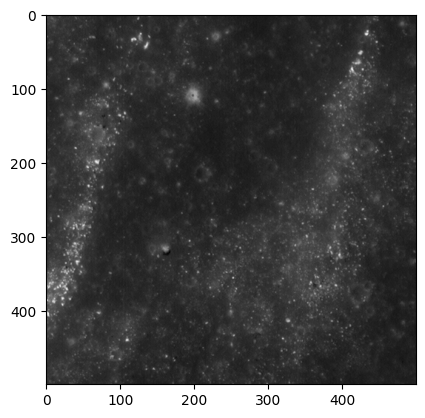

In [59]:
plt.imshow(data_image[323], cmap="gray")

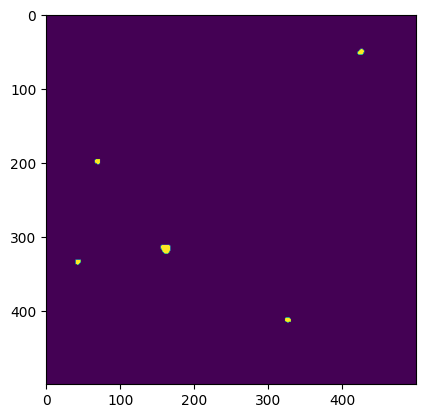

In [60]:
plt.imshow(data_labels[323])